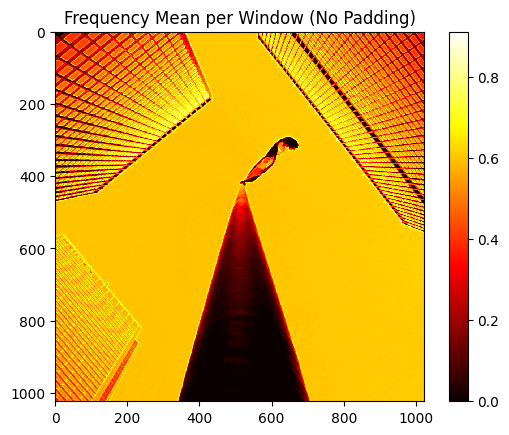

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from matplotlib.image import imread

# 加载图像
def fft_mapping():
    image = imread('/home/yinqiang/fourier-feature-networks/0188.png')
    c = [image.shape[0]//2, image.shape[1]//2]
    r = 512
    image = image[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
    def channel_level_fft(channel):
        # 假设是灰度图像或只取一个通道进行演示
         # 如果是彩色图像，这里以R通道为例

        # 定义窗口大小和半窗口
        window_size = 3
        half_window = window_size // 2

        # 初始化一个与原图像同尺寸的数组，用于存放每个窗口的频率均值
        freq_means = np.zeros_like(channel, dtype=float)

        # 计算可用于窗口中心的图像范围，以避免边缘外的窗口
        x_range = range(half_window, channel.shape[0] - half_window)
        y_range = range(half_window, channel.shape[1] - half_window)

        for x in x_range:
            for y in y_range:
                # 提取以(x, y)为中心的窗口
                local_window = channel[x-half_window:x+half_window+1, y-half_window:y+half_window+1]

                # 计算窗口的FFT
                local_fft = fft2(local_window)

                # 计算FFT的幅度
                magnitude = np.abs(local_fft)

                # 计算幅度的均值，并赋值给中心像素位置
                freq_means[x, y] = np.mean(magnitude)

        # 对频率均值进行对数转换以改善可视化效果
        freq_means_log = np.log1p(freq_means)  # np.log1p等价于np.log(1 + x)，用于增加数值稳定性
        return freq_means_log
    freq_r = channel_level_fft(image[:,:,0])
    freq_g = channel_level_fft(image[:,:,1])
    freq_b = channel_level_fft(image[:,:,2])
    return (freq_r+freq_g+freq_b)/3
freq_means_log = fft_mapping()
plt.imshow(freq_means_log, cmap='hot', interpolation='nearest')
plt.title('Frequency Mean per Window (No Padding)')
plt.colorbar()
plt.show()

cuda:0


/tmp/ipykernel_2721642/1610346037.py:37: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path)[..., :3] / 255.


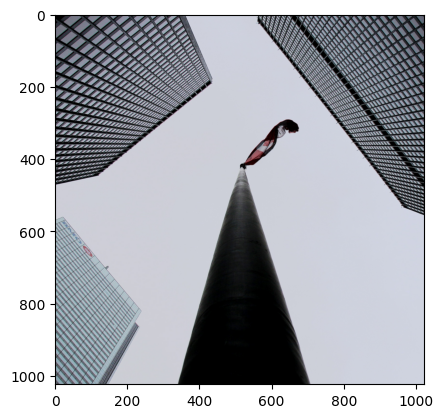

In [2]:
#@title Imports and Boilerplate

import urllib.request

import torch

import torch.nn as nn
import tqdm

import numpy as np
import cv2

import cv2
import imageio
import torch
import numpy as np
from tqdm.notebook import tqdm as tqdm
from torch import nn
import matplotlib.pyplot as plt

def tensor_to_numpy(tensor: torch.Tensor) -> np.ndarray:
    tensor = tensor * 256
    tensor[tensor > 255] = 255
    tensor[tensor < 0] = 0
    tensor = tensor.type(torch.uint8).permute(1, 2, 0).cpu().numpy()

    return tensor

def get_image():
    # image_url = 'https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg'
    # img = imageio.imread(image_url)[..., :3] / 255.
    # c = [img.shape[0] // 2, img.shape[1] // 2]
    # r = 256
    # img = img[c[0] - r:c[0] + r, c[1] - r:c[1] + r]
    image_path = '/home/yinqiang/yzw/datasets/div_bad_25_100/0188.png'
    # Reading the image from the local filesystem
    img = imageio.imread(image_path)[..., :3] / 255.
    c = [img.shape[0]//2, img.shape[1]//2]
    r = 512
    img = img[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
    return img
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
def get_psnr(img, output):
    block_original = img
    block_processed = output
    psnr_value = psnr(block_original, block_processed, data_range=255)

    return psnr_value
def save_img(generated, save_dir):
    from torchvision.utils import save_image
    import os
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # 保存图像，这里仅保存批量中的第一个图像作为示例
    save_path = os.path.join(save_dir, "generated_image.png")
    save_image(generated[0], save_path)

    print(f"Generated image saved to {save_path}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Get an image that will be the target for our model.
target = torch.tensor(get_image()).unsqueeze(0).permute(0, 3, 1, 2).to(device)
plt.imshow(tensor_to_numpy(target[0]))
plt.show()

# Create input pixel coordinates in the unit square. This will be the input to the model.
coords_x = np.linspace(0, 1, target.shape[3], endpoint=False)
coords_y = np.linspace(0, 1, target.shape[2], endpoint=False)
xy_grid = np.stack(np.meshgrid(coords_x, coords_y), -1)
xy_grid = torch.tensor(xy_grid).unsqueeze(0).permute(0, 3, 1, 2).float().contiguous().to(device)

from math import log2
class Embedder(nn.Module):
    def __init__(self, num_freqs, scale):
        super(Embedder, self).__init__()
        self.num_freqs = num_freqs
        self.scale = scale
        self.create_embedding_fn()
        
    def create_embedding_fn(self):
        embed_fns = []
        d = 2
        out_dim = 0
        if False:
            embed_fns.append(lambda x : x)
            out_dim += d
            
        max_freq = log2(self.scale)
        N_freqs = self.num_freqs
        

        freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)

        for freq in freq_bands:
            for p_fn in [torch.sin, torch.cos]:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(2*torch.pi* x * freq))
                out_dim += d
                    
        self.embed_fns = embed_fns
        self.out_dim = out_dim
        
    def forward(self, inputs):
        return torch.cat([fn(inputs) for fn in self.embed_fns], 1)

In [3]:
from torch.utils.data import Dataset, DataLoader


In [4]:
import torch
import torch.nn as nn
from numpy import log2
from torch.utils.data import Dataset, DataLoader
import torch
class CoordinateDataset(Dataset):
    def __init__(self, coordinate_tensor, freq_means_log, num_freqs):
        """
        coordinate_tensor: 形状为 [1, 2, H, W] 的张量，
                           其中 coordinate_tensor[0, 0, :, :] 表示 x 坐标，
                           coordinate_tensor[0, 1, :, :] 表示 y 坐标。
        """
        self.coordinate_tensor = coordinate_tensor.to("cpu")
        self.freq_means_log = freq_means_log
        self.num_freqs = num_freqs
        self.height = coordinate_tensor.size(2)
        self.width = coordinate_tensor.size(3)
    
    def __len__(self):
        # 数据集的总长度等于所有可能的坐标点数
        return self.height * self.width
    
    def __getitem__(self, idx):
        # 将一维索引转换为二维坐标位置
        y_idx = idx // self.width
        x_idx = idx % self.width
        
        # 获取对应的坐标值
        x_coordinate = int(self.coordinate_tensor[0, 0, y_idx, x_idx].item()*self.width)
        y_coordinate = int(self.coordinate_tensor[0, 1, y_idx, x_idx].item()*self.height)
        embed_fns = []
        scale = 30*self.freq_means_log[y_coordinate, x_coordinate]**2 + 10

        max_freq = log2(scale)
        N_freqs = self.num_freqs
        freq_bands = 2.**torch.linspace(0., max_freq, steps=N_freqs)
        for freq in freq_bands:
            for p_fn in [torch.sin, torch.cos]:
                embed_fns.append(lambda x, p_fn=p_fn, freq=freq : p_fn(2 * torch.pi * x * freq))
        
        return torch.cat([fn(self.coordinate_tensor[0][:,y_coordinate,x_coordinate]) for fn in embed_fns]),x_coordinate, y_coordinate

class PositionalEncoder(nn.Module):
    def __init__(self, num_freqs, freq_means_log):
        super(PositionalEncoder, self).__init__()
        self.num_freqs = num_freqs
        self.freq_means_log = freq_means_log

    def forward(self, inputs):
        encoded = torch.zeros(1, self.num_freqs*4, inputs.shape[2], inputs.shape[3], device=device)
        dataset = CoordinateDataset(inputs, self.freq_means_log, self.num_freqs)
        dataloader = DataLoader(dataset, batch_size=256, shuffle=False, num_workers=12)  # 根据需要设置 batch_size
        for coordinates in tqdm(dataloader):

            encoded[0,:,coordinates[2],coordinates[1]] = coordinates[0].to(device).T
        print("finished")        
        return encoded


  0%|          | 0/4096 [00:00<?, ?it/s]

finished


  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0, loss = 0.306


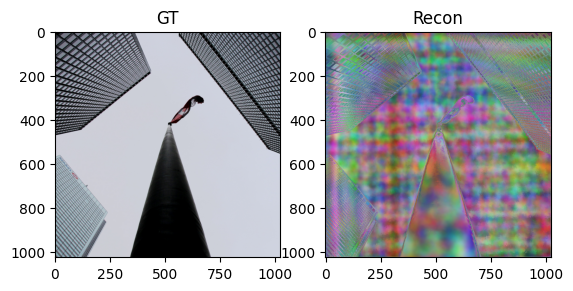

psnr for upper block is  10.3491603930241
psnr for lower block is  8.64505945664744
psnr for whole image is  9.251401339650778
Epoch 1000, loss = 0.042


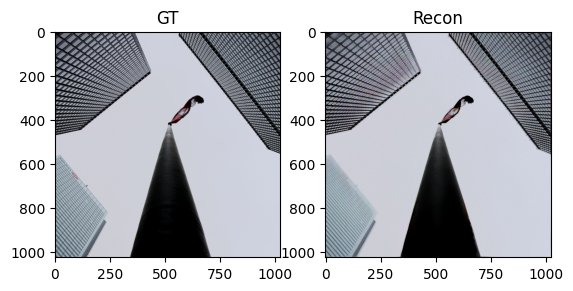

psnr for upper block is  15.79260018780069
psnr for lower block is  42.2468953033441
psnr for whole image is  20.157425314908238
Epoch 2000, loss = 0.041


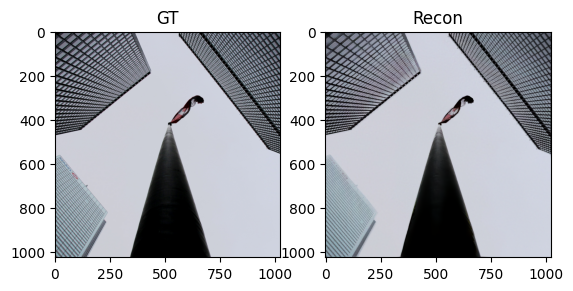

psnr for upper block is  15.90217640460213
psnr for lower block is  48.978802185732214
psnr for whole image is  20.348571221657664
Epoch 3000, loss = 0.040


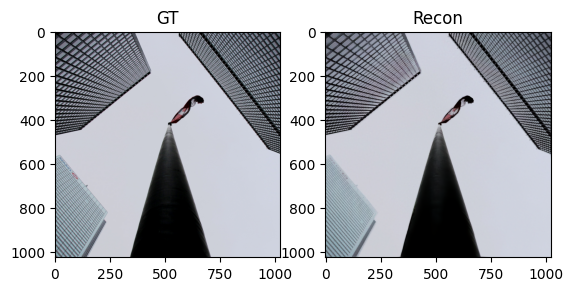

psnr for upper block is  15.952000293380845
psnr for lower block is  48.08737291939288
psnr for whole image is  20.424485294769568
Epoch 4000, loss = 0.040


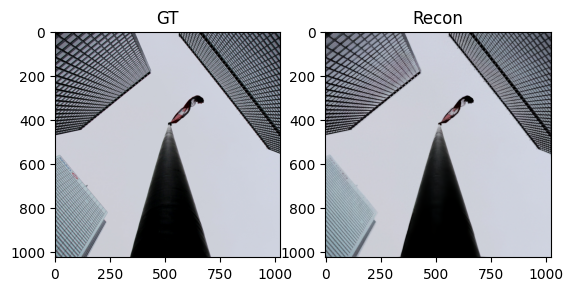

psnr for upper block is  16.001330459453282
psnr for lower block is  48.733046427373765
psnr for whole image is  20.47955249875518
Epoch 5000, loss = 0.039


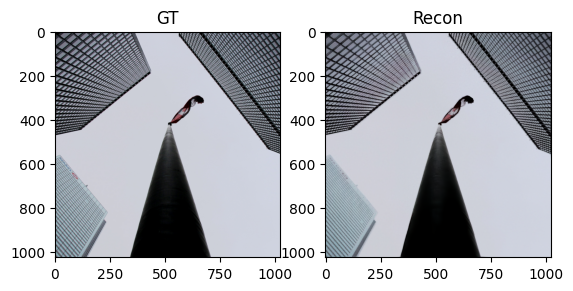

psnr for upper block is  16.012871221191425
psnr for lower block is  49.63863629084134
psnr for whole image is  20.51732614697467
Epoch 6000, loss = 0.039


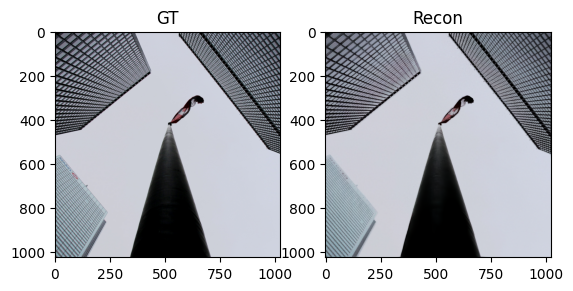

psnr for upper block is  16.08434365435601
psnr for lower block is  49.800793941695936
psnr for whole image is  20.55247804924699
Epoch 7000, loss = 0.039


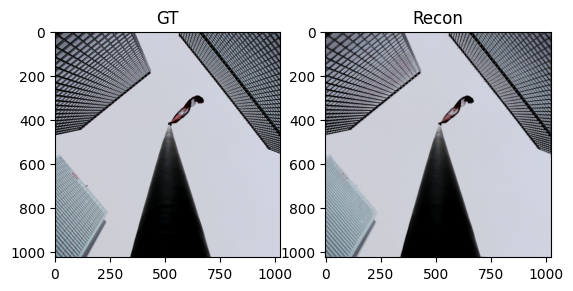

psnr for upper block is  16.082469604648864
psnr for lower block is  50.143083357274506
psnr for whole image is  20.573984828765425
Epoch 8000, loss = 0.039


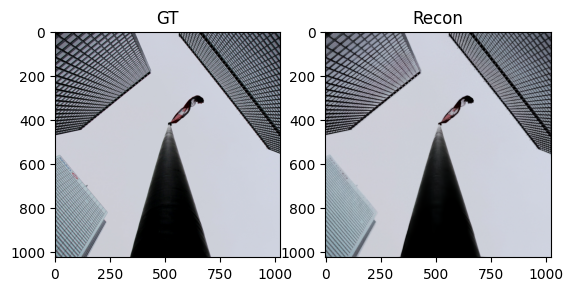

psnr for upper block is  16.105690889413022
psnr for lower block is  49.379513620558356
psnr for whole image is  20.591870923498917
Epoch 9000, loss = 0.039


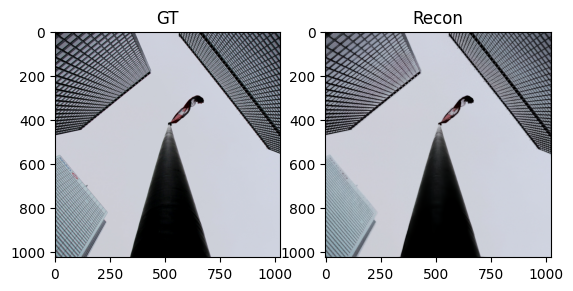

psnr for upper block is  16.12072557440244
psnr for lower block is  49.671109813939054
psnr for whole image is  20.607848305366314
Epoch 9999, loss = 0.039


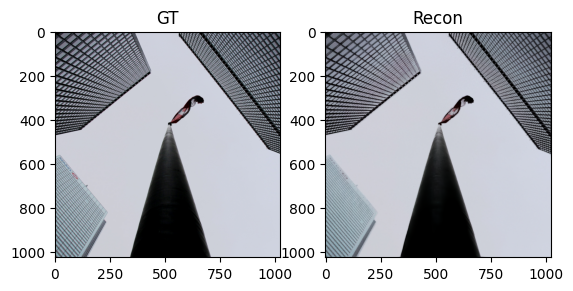

psnr for upper block is  16.152475833828237
psnr for lower block is  50.07377364708859
psnr for whole image is  20.629133265509807
Generated image saved to /home/yinqiang/fourier-feature-networks/Result_188/Adaptive_comp_1024/generated_image.png


In [5]:

torch.cuda.empty_cache()
model = nn.Sequential(
        nn.Conv2d(
            512,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            256,
            kernel_size=1,
            padding=0),
        nn.ReLU(),
        nn.BatchNorm2d(256),

        # nn.Conv2d(
        #     256,
        #     256,
        #     kernel_size=1,
        #     padding=0),
        # nn.ReLU(),
        # nn.BatchNorm2d(256),

        nn.Conv2d(
            256,
            3,
            kernel_size=1,
            padding=0),
        nn.Sigmoid(),

    ).to(device)

# Note: this can be done outside of the training loop, since the result at this stage is unchanged during the course of training.
x = PositionalEncoder(128, freq_means_log)(xy_grid)

optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-4)

for epoch in tqdm(range(10000)):
    # torch.cuda.empty_cache()
    optimizer.zero_grad()

    generated = model(x)

    loss = torch.nn.functional.l1_loss(target, generated)

    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(tensor_to_numpy(target[0]))
      ax1.set_title('GT')  # 设置子图的标题
      ax2.imshow(tensor_to_numpy(generated[0]))
      ax2.set_title('Recon')  # 设置子图的标题
      
      plt.show()
      target_np = tensor_to_numpy(target[0])
      generated_np = tensor_to_numpy(generated[0])
      print("psnr for upper block is ", get_psnr(target_np[0:256, 0:256], generated_np[0:256, 0:256]))
      height, width, _ = target_np.shape
      print("psnr for lower block is ", get_psnr(target_np[height-256:height, width-256:width], generated_np[height-256:height, width-256:width]))  
      print("psnr for whole image is ", get_psnr(target_np, generated_np))
    if epoch == 9999:
      print('Epoch %d, loss = %.03f' % (epoch, float(loss)))
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(tensor_to_numpy(target[0]))
      ax1.set_title('GT')  # 设置子图的标题
      ax2.imshow(tensor_to_numpy(generated[0]))
      ax2.set_title('Recon')  # 设置子图的标题
      
      plt.show()
      target_np = tensor_to_numpy(target[0])
      generated_np = tensor_to_numpy(generated[0])
      print("psnr for upper block is ", get_psnr(target_np[0:256, 0:256], generated_np[0:256, 0:256]))
      height, width, _ = target_np.shape
      print("psnr for lower block is ", get_psnr(target_np[height-256:height, width-256:width], generated_np[height-256:height, width-256:width]))  
      print("psnr for whole image is ", get_psnr(target_np, generated_np))
      save_img(generated, save_dir = "/home/yinqiang/fourier-feature-networks/Result_188/Adaptive_comp_1024")